In [1]:
import librosa

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

In [2]:
import torchaudio
from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

100%|██████████| 106k/106k [00:00<00:00, 11.9MB/s]


## KISS approach

In [132]:
wav, sr = librosa.load(SAMPLE_WAV, sr = 16000)
print(wav.shape)
print(sr)

(54400,)
16000


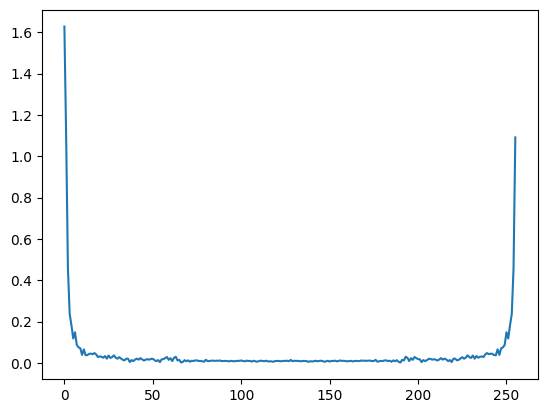

In [15]:
a = np.fft.fft(wav[:400], n = 256)
a = np.abs(a)
plt.plot(a)

In [8]:
np.zeros(2)

array([0., 0.])

In [30]:
def _hann_window(frame_length):
    return (0.5 - 0.5*np.cos(2*np.pi*np.arange(0, 1.0, 1.0/frame_length))).astype(np.float32)
han_window = _hann_window(480)
han_window.shape

(480,)

In [95]:
def kiss_spectrogram(waveform,
                     sample_rate,
                     n_fft,
                     win_length,
                     hop_length,
                     power = 2):
    fft_stack = []
    len_wav = len(waveform)
    hann_win = _hann_window(win_length)
    for i in range(len_wav//hop_length+1):
        swav = waveform[hop_length*i: min(hop_length*i+win_length, len_wav)]
        len_swav = len(swav)
        if len_swav < win_length:
           pad = np.zeros(win_length - len_swav)
           swav = np.concatenate((swav, pad))
        swav = swav*hann_win
        fft_stack.append(np.fft.fft(swav, n = n_fft)[:n_fft//2+1])
    spec = np.stack(fft_stack, axis = 0)
    spec = np.abs(spec)**power
    return spec

In [133]:
spec = kiss_spectrogram(wav,
                        16000,
                        512,
                        480,
                        160,
                        power = 1)
spec.shape

(341, 257)

In [134]:
spec.max()

37.71415234915527

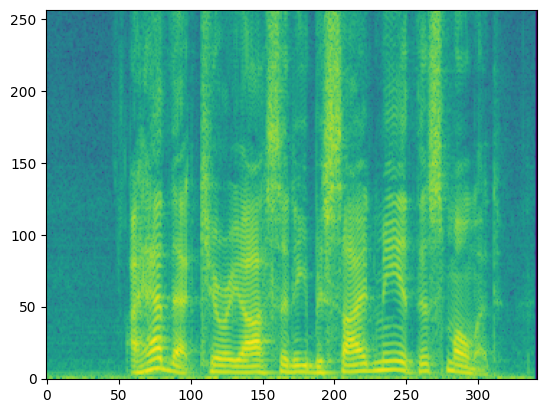

In [135]:
plt.imshow(np.log(spec + 1e-6).T, origin = 'lower')

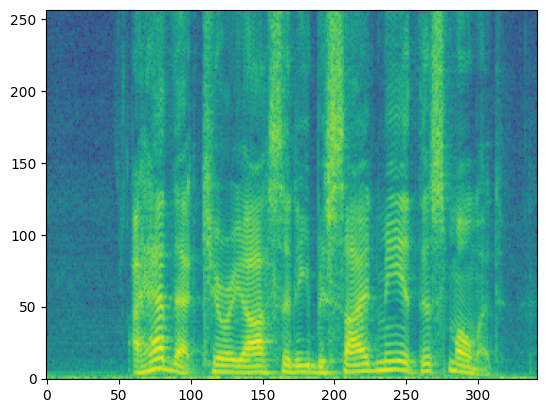

In [45]:
import torch

torch_wav, sr = torchaudio.load(SAMPLE_WAV)
torch_spec = torchaudio.transforms.Spectrogram(n_fft = 512,
                                               win_length = 480,
                                               hop_length = 160,
                                               power = 1)(torch_wav)
plt.imshow(torch.log(torch_spec + 1e-6).squeeze(), origin = 'lower')

In [64]:
torch_spec.shape

torch.Size([1, 257, 341])

In [46]:
torch_spec.max()

tensor(38.9575)

In [57]:
from typing import Optional
import tensorflow as tf
from tensorflow import keras

class Spectrogram(keras.Model):
    def __init__(self,
                 sample_rate: int = 16000,
                 n_fft: int = 400,
                 win_length: Optional[int] = None,
                 hop_length: Optional[int] = None,
                 pad_end: bool = False,
                 power: float = 2.0) -> None:
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else win_length//2
        self.pad_end = pad_end
        self.power = power

    def call(self, waveform: tf.Tensor) -> tf.Tensor:
        spectrogram = tf.abs(tf.signal.stft(
                signals = waveform,
                frame_length = self.win_length,
                frame_step = self.hop_length,
                fft_length = self.n_fft,
                pad_end = self.pad_end
            ))
        if self.power == 2:
            spectrogram = spectrogram*spectrogram
        return spectrogram

In [61]:
tf_spec = Spectrogram(n_fft = 512,
                      win_length = 480,
                      hop_length = 160,
                      pad_end = True,
                      power = 1)(wav).numpy()
tf_spec.shape

(340, 257)

In [62]:
tf_spec.max()

37.714153

In [104]:
np.abs(tf_spec-spec[:340]).sum()

0.008498986628004707

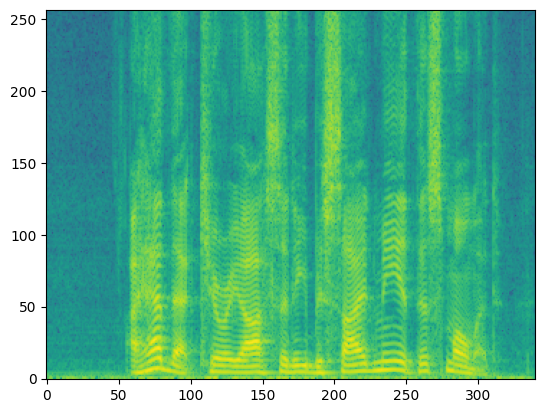

In [63]:
plt.imshow(np.log(tf_spec + 1e-6).T, origin = 'lower')

In [195]:
def onl_spectrogram(waveform,
                    buffer_size,
                    n_fft,
                    win_length,
                    hop_length,
                    power = 2):
    spec_stack = []
    len_wav = len(waveform)
    for i in range(len_wav//buffer_size+1):
        swav = waveform[i*buffer_size: min((i+1)*buffer_size, len_wav)]
        sspec = kiss_spectrogram(swav, 16000, n_fft, win_length, hop_length, power)
        spec_stack.append(sspec[:-1])
    spec = np.concatenate(spec_stack, axis = 0)
    return spec

In [196]:
onl_spec = onl_spectrogram(wav, 480, 512, 480, 160, 1)
onl_spec.shape

(340, 257)

In [197]:
onl_spec.max()

37.71415234915527

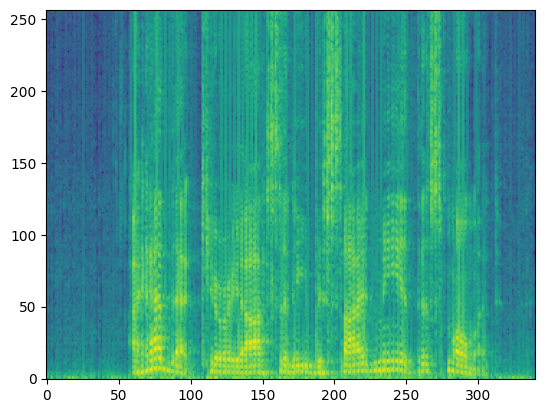

In [198]:
plt.imshow(np.log(onl_spec + 1e-6).T, origin = 'lower')

In [200]:
np.abs(onl_spec - tf_spec).mean()

0.14628375897436982